In [1]:
import pandas as pd
import csv
from system import *
from analye_model import *
from plot_rooflines import *
from operators import GEMM, SoftMax
from operators_attn import Logit, Attend
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Lab Layout 
Part B.1: Operator Fusion - 4 points
-	Implementing operator fusion
-	Identifying various fusion operations opportunities among different operations.


Part B.2: Dataflow aware roofline - 3 points.
-	A stationary
-	B stationary
-	C stationary
-	Bonus – 1 point

Part B.3: Quantization of data – 1 points
-	Data fetch quantization
-	Quantization with different compute units.




In [2]:
## A100 https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/a100/pdf/nvidia-a100-datasheet-us-nvidia-1758950-r4-web.pdf
A100_GPU = System( offchip_mem_bw=1935,
                   flops=314, frequency=1095 ,
                   compute_efficiency=0.75, memory_efficiency=0.7)

## B.1 Operator Fusion
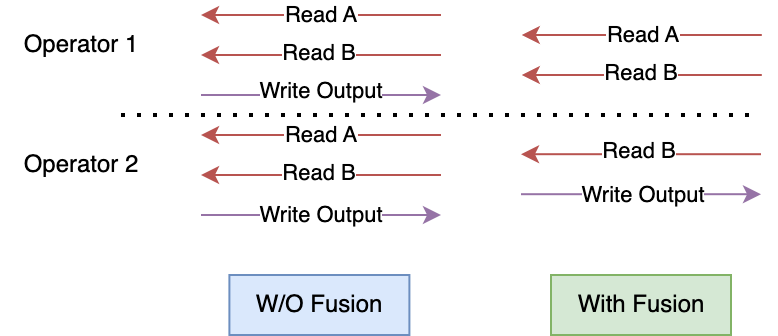

#### TODO B.1.i) Implement operator fusion

In [3]:
model_b1i = [
            GEMM([1, 128, 128, 512 ]),
            GEMM([1, 128, 10240, 128 ]),
            GEMM([1, 128, 1, 10240 ]),
            GEMM([1, 128, 64, 1 ]),
            GEMM([1, 128, 128, 64 ]),
            GEMM([1, 128, 256, 128 ]),
            ]
model_b1i_wo_fusion = analysis_model(model_b1i, A100_GPU, fusion = [])
display(model_b1i_wo_fusion)
print(f'Total Cycles:{sum(model_b1i_wo_fusion.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b1i_wo_fusion.loc[:, "Total Data (MB)"]):0.2f}')

model_b1i_with_fusion = analysis_model(model_b1i, A100_GPU, fusion = [(1,2,3),(4,5)])
display(model_b1i_with_fusion)
print(f'Total Cycles:{sum(model_b1i_with_fusion.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b1i_with_fusion.loc[:, "Total Data (MB)"]):0.2f}')

model_b1i_with_fusion.to_csv('output_b1.csv', index=False)

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 128, 128, 512]",M,0.35,113.67,0.00,444.08,16.76,0.06,0.06,0.02,0.14,41.33,155.87,444.08
1,GEMM,"[1, 128, 10240, 128]",M,0.39,126.71,0.01,7944.03,334.23,0.02,1.25,1.25,2.52,46.07,3108.16,7944.03
2,GEMM,"[1, 128, 1, 10240]",M,0.01,1.98,0.00,3978.57,2.62,1.25,0.01,0.00,1.26,0.72,24.38,3978.57
3,GEMM,"[1, 128, 64, 1]",M,0.00,0.98,0.00,25.25,0.01,0.00,0.00,0.01,0.01,0.36,0.08,25.25
4,GEMM,"[1, 128, 128, 64]",M,0.20,63.50,0.00,98.68,2.08,0.01,0.01,0.02,0.03,23.09,19.35,98.68
5,GEMM,"[1, 128, 256, 128]",M,0.31,102.00,0.00,246.71,8.36,0.02,0.03,0.03,0.08,37.09,77.70,246.71


Total Cycles:12737.32, Total data (MB): 4.03


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 128, 128, 512]",M,0.35,113.67,0.00,444.08,16.76,0.06,0.06,0.02,0.14,41.33,155.87,444.08
1,GEMM,"[1, 128, 10240, 128]",M,0.39,126.71,0.01,7944.03,334.23,0.02,1.25,1.25,2.52,46.07,3108.16,7944.03
2,GEMM,"[1, 128, 1, 10240]",M,0.78,1.98,0.00,31.22,2.62,1.25,0.01,0.00,1.26,91.93,24.38,31.22
3,GEMM,"[1, 128, 64, 1]",M,0.00,0.98,0.00,24.86,0.01,0.00,0.00,0.01,0.01,0.36,0.08,24.86
4,GEMM,"[1, 128, 128, 64]",M,0.20,63.50,0.00,98.68,2.08,0.01,0.01,0.02,0.03,23.09,19.35,98.68
5,GEMM,"[1, 128, 256, 128]",M,0.39,102.00,0.00,197.37,8.36,0.02,0.03,0.03,0.08,46.36,77.70,197.37


Total Cycles:8740.25, Total data (MB): 4.03


### TODO B.1.ii) Finding best fusion strategy.

You are allowed to perform any number of legal pairwise fusions. Legal pairwise fusion is fusing any 2 operations that are connected in the graph by arrow. <br>

Q. Identify the minimum number of operator fusion that can speed up this network, and which specific pairs help speed up the network? 

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 3072, 1024]",C,2.71,877.29,0.05,59881.44,6439.31,1.00,3.00,3.00,7.00,117.75,59881.44,22105.14
1,Logit,"[1, 16, 1024, 1024, 64]",M,0.18,56.89,0.05,56841.78,1073.74,1.00,1.00,16.00,18.00,20.68,9985.12,56841.78
2,Attend,"[1, 16, 1024, 1024, 64]",M,0.18,56.89,0.05,56841.78,1073.74,16.00,1.00,1.00,18.00,20.68,9985.12,56841.78
3,SoftMax,"[16384, 1024]",M,0.04,12.50,0.09,101052.05,419.41,16.00,0.00,16.00,32.00,4.54,3900.28,101052.05
4,GEMM,"[1, 1024, 1024, 1024]",C,2.11,682.33,0.02,19960.48,2146.44,1.00,1.00,1.00,3.00,117.75,19960.48,9473.63
5,GEMM,"[1, 1024, 4096, 1024]",C,2.81,909.78,0.07,79841.92,8585.74,1.00,4.00,4.00,9.00,117.75,79841.92,28420.89
6,GEMM,"[1, 1024, 1024, 4096]",C,2.81,910.11,0.07,79871.17,8588.89,4.00,4.00,1.00,9.00,117.75,79871.17,28420.89


Total Cycles:454290.60, Total data (MB): 96.00


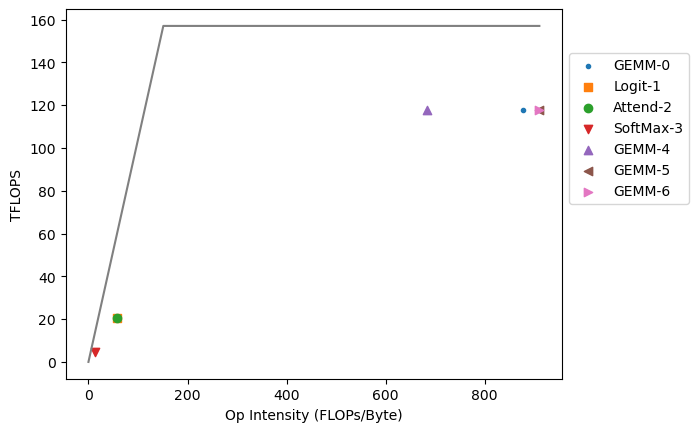

In [4]:
## Coded below is a typical transformer layer. 
B, H, N, D = 1, 16, 1024 , 1024
model_b1ii = [GEMM([B, N, D*3, D ]),
            Logit([B, H, N, N, D//H ]),
            Attend([B, H, N, N, D//H]),
            SoftMax([B*H*N, N]),
            GEMM([B, N, D, D ]), 
            GEMM([B, N, 4*D, D ]),
            GEMM([B, N, D, 4*D ])]

unoptimized_model = analysis_model(model_b1ii, A100_GPU)
display(unoptimized_model)
dot_roofline(unoptimized_model, A100_GPU)
print(f'Total Cycles:{sum(unoptimized_model.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(unoptimized_model.loc[:, "Total Data (MB)"]):0.2f}')


#### Iteratively find the least number of fusion to optimize the runtime.

In [5]:
optimized_model = analysis_model(model_b1ii, A100_GPU, fusion = [(1,2),(0,3)])
display(optimized_model)
print(f'Total Cycles:{sum(optimized_model.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(optimized_model.loc[:, "Total Data (MB)"]):0.2f}')

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 3072, 1024]",C,2.71,877.29,0.05,59881.44,6439.31,1.00,3.00,3.00,7.00,117.75,59881.44,22105.14
1,Logit,"[1, 16, 1024, 1024, 64]",M,0.18,56.89,0.05,56841.78,1073.74,1.00,1.00,16.00,18.00,20.68,9985.12,56841.78
2,Attend,"[1, 16, 1024, 1024, 64]",C,1.58,56.89,0.01,9985.12,1073.74,16.00,1.00,1.00,18.00,117.75,9985.12,6315.75
3,SoftMax,"[16384, 1024]",M,0.08,12.50,0.05,50526.02,419.41,16.00,0.00,16.00,32.00,9.09,3900.28,50526.02
4,GEMM,"[1, 1024, 1024, 1024]",C,2.11,682.33,0.02,19960.48,2146.44,1.00,1.00,1.00,3.00,117.75,19960.48,9473.63
5,GEMM,"[1, 1024, 4096, 1024]",C,2.81,909.78,0.07,79841.92,8585.74,1.00,4.00,4.00,9.00,117.75,79841.92,28420.89
6,GEMM,"[1, 1024, 1024, 4096]",C,2.81,910.11,0.07,79871.17,8588.89,4.00,4.00,1.00,9.00,117.75,79871.17,28420.89


Total Cycles:356907.92, Total data (MB): 96.00


#### Once fusion operations are finalized, generate the csv file

In [6]:
optimized_model.to_csv('output_b2.csv', index=False)

#### Q. Comment on the type of operations that benefit from operator fusion. Why do you think, operator fusion is able to help in bringing the runtime down?



The types of operations that benefit are operations 0 to 3 (GEMM, Logit, Attend, SoftMax). Logit and SoftMax happen to be memory-bound, and with operator fusion, it helped to reduce memory accesses significantly which in turn helped to bring the runtime down. They also happen to have large intermediate matrices which may cause large overhead when reading and writing from memory and as such fused operations would help to reduce that.

## B.2 Dataflow aware roofline

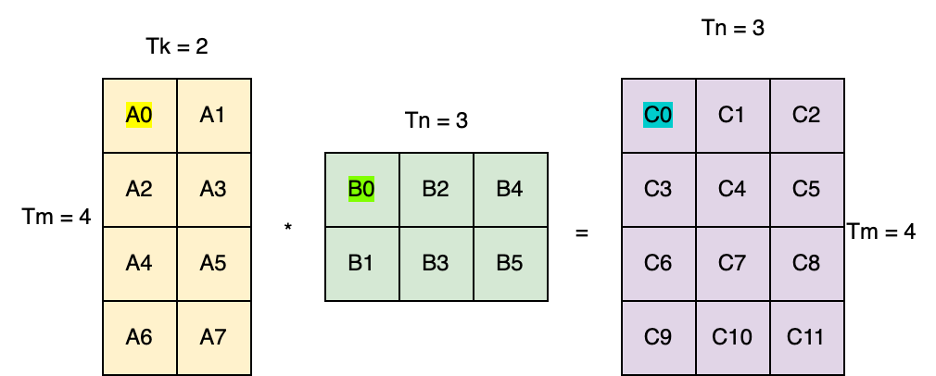

### B.2.i) A stationary
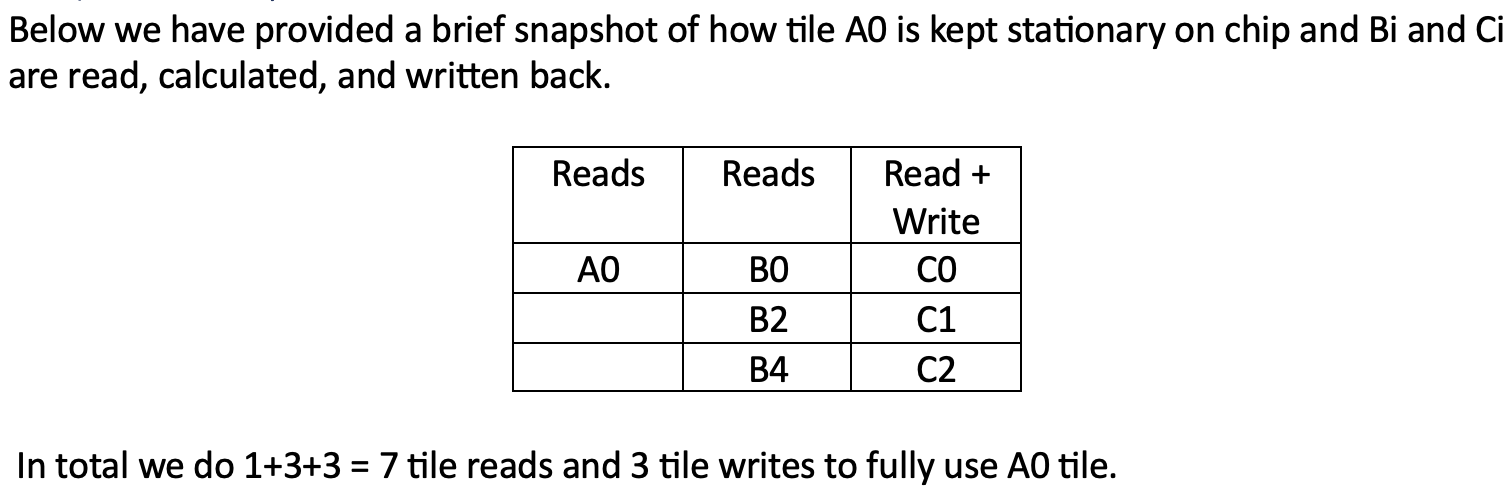

Calculate total number of memory access for A stationary: f(Tm, Tn, Tk)* A + g(Tm, Tn, Tk)* B + h(Tm, Tn, Tk)* C

### B.2.ii) B stationary
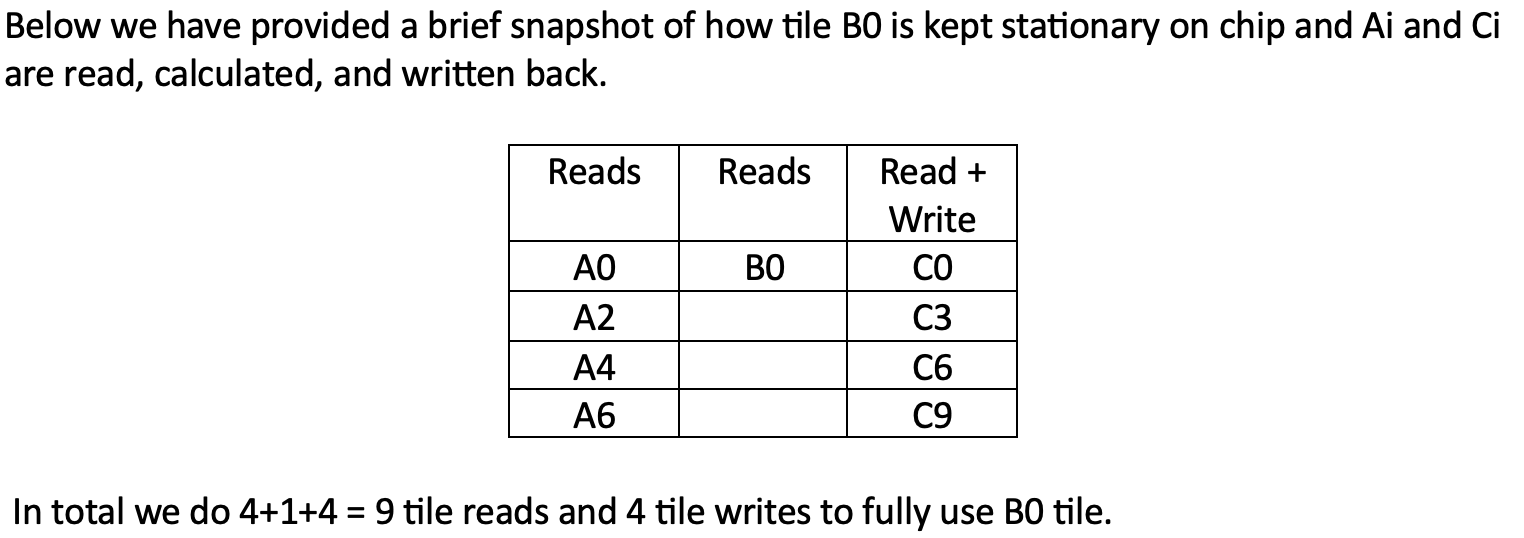

Calculate total number of memory access for B stationary: f(Tm, Tn, Tk)* A + g(Tm, Tn, Tk)* B + h(Tm, Tn, Tk)* C

### B.2.iii) C stationary
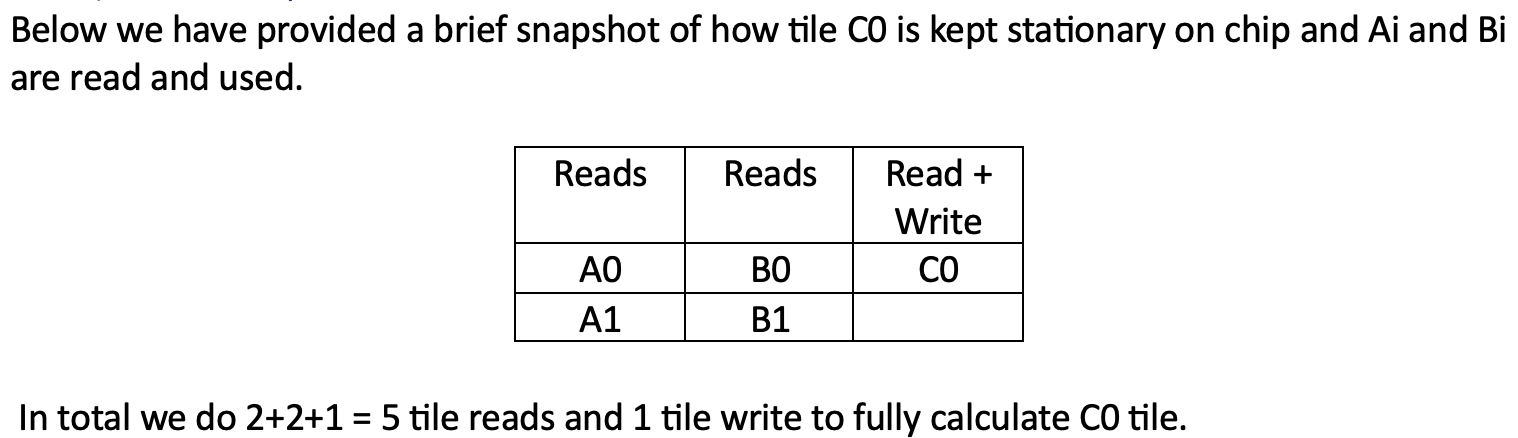

Calculate total number of memory access for C stationary: f(Tm, Tn, Tk)* A + g(Tm, Tn, Tk)* B + h(Tm, Tn, Tk)* C

In [7]:
model_b2 = [ GEMM([1, 4096 , 1024, 6144])]
# Size of each tile of A  = 1024 x 2048
# Size of each tile of B = 2048 x 512
# Size of each Output tile = 1024 x 512
model_b2_a_tiling = analysis_model(model_b2, A100_GPU, tiling = 'A', Tm = 4, Tk = 3, Tn = 2)
display(model_b2_a_tiling)
print(f'Total Cycles:{sum(model_b2_a_tiling.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b2_a_tiling.loc[:, "Total Data (MB)"]):0.2f}')

model_b2_b_tiling = analysis_model(model_b2, A100_GPU, tiling = 'B', Tm = 4, Tk = 3, Tn = 2)
display(model_b2_b_tiling)
print(f'Total Cycles:{sum(model_b2_b_tiling.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b2_b_tiling.loc[:, "Total Data (MB)"]):0.2f}')

model_b2_c_tiling = analysis_model(model_b2, A100_GPU, tiling = 'C', Tm = 4, Tk = 3, Tn = 2)
display(model_b2_c_tiling)
print(f'Total Cycles:{sum(model_b2_c_tiling.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b2_c_tiling.loc[:, "Total Data (MB)"]):0.2f}')

model_b2_a_tiling.to_csv('output_b3a.csv', index=False)
model_b2_b_tiling.to_csv('output_b3b.csv', index=False)
model_b2_c_tiling.to_csv('output_b3c.csv', index=False)

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 4096, 1024, 6144]",C,2.53,1445.53,0.44,479246.52,51535.41,24.00,6.00,4.00,34.00,117.75,479246.52,189472.59


Total Cycles:479246.52, Total data (MB): 34.00


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 4096, 1024, 6144]",C,2.30,1445.53,0.44,479246.52,51535.41,24.00,6.00,4.00,34.00,117.75,479246.52,208419.85


Total Cycles:479246.52, Total data (MB): 34.00


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 4096, 1024, 6144]",C,2.00,1445.53,0.44,479246.52,51535.41,24.00,6.00,4.00,34.00,117.75,479246.52,239998.62


Total Cycles:479246.52, Total data (MB): 34.00


### B.2.iv) Best Tiling
Find the tiling strategy that would require minimum fewer number of memory access compared to these three strategies. 

Explain the strategy by giving example in form a table of reads and write for Ai, Bi, Ci. Also derive the f , g, & h  for the best strategy.


## B.3 Quantization of data

Various datatype possible = bf16, int8, fp32, fp64.

### B.3.i) Quantizing data access 

In [8]:
model_b3 =  [
            GEMM([1, 1024, 128, 512 ]),
            GEMM([1, 128, 256, 128 ]),
            GEMM([1, 1024, 512, 256 ])
            ]

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 128, 512]",M,0.57,186.00,0.00,2171.04,134.09,0.50,0.06,0.12,0.69,67.63,1246.92,2171.04
1,GEMM,"[1, 128, 256, 128]",M,0.31,102.00,0.00,246.71,8.36,0.02,0.03,0.03,0.08,37.09,77.70,246.71
2,GEMM,"[1, 1024, 512, 256]",M,0.90,292.00,0.00,2763.14,267.91,0.25,0.12,0.50,0.88,106.17,2491.40,2763.14


Total Cycles:5180.89, Total data (MB): 1.64


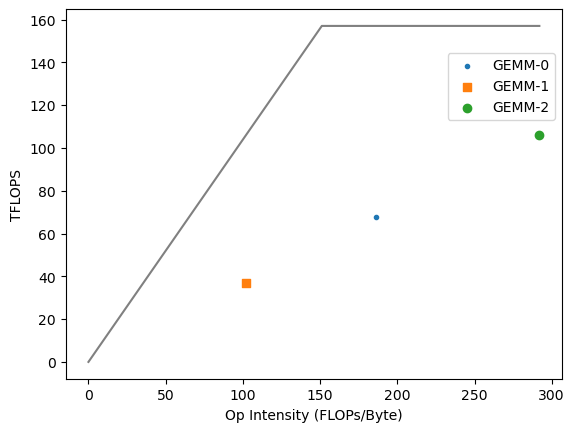

In [9]:
model_b3_fp32 = analysis_model(model_b3, A100_GPU)
display(model_b3_fp32)

dot_roofline(model_b3_fp32, A100_GPU)
print(f'Total Cycles:{sum(model_b3_fp32.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b3_fp32.loc[:, "Total Data (MB)"]):0.2f}')

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 128, 512]",C,2.30,186.00,0.00,1246.92,134.09,0.50,0.06,0.12,0.69,117.75,1246.92,542.76
1,GEMM,"[1, 128, 256, 128]",C,1.26,102.00,0.00,77.70,8.36,0.02,0.03,0.03,0.08,117.75,77.70,61.68
2,GEMM,"[1, 1024, 512, 256]",C,3.61,292.00,0.00,2491.40,267.91,0.25,0.12,0.50,0.88,117.75,2491.40,690.79


Total Cycles:3816.03, Total data (MB): 1.64


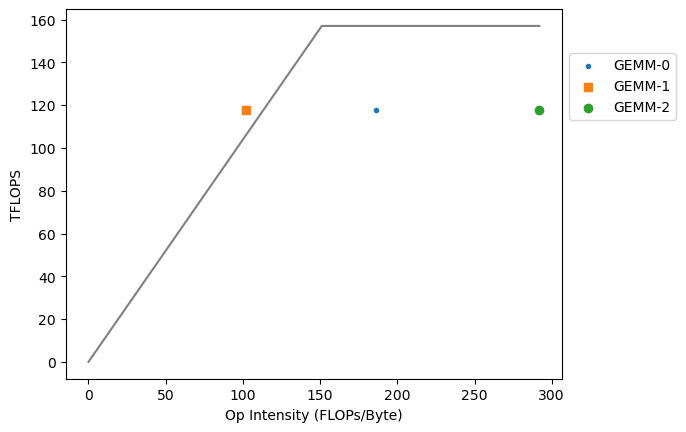

In [10]:
model_b3_int8 = analysis_model(model_b3, A100_GPU, data_format_mem='int8')
display(model_b3_int8)

dot_roofline(model_b3_int8, A100_GPU)
print(f'Total Cycles:{sum(model_b3_int8.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b3_int8.loc[:, "Total Data (MB)"]):0.2f}')
model_b3_int8.to_csv('output_b4a.csv', index=False)

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 128, 512]",C,1.15,186.00,0.00,1246.92,134.09,0.50,0.06,0.12,0.69,117.75,1246.92,1085.52
1,GEMM,"[1, 128, 256, 128]",M,0.63,102.00,0.00,123.35,8.36,0.02,0.03,0.03,0.08,74.17,77.70,123.35
2,GEMM,"[1, 1024, 512, 256]",C,1.80,292.00,0.00,2491.40,267.91,0.25,0.12,0.50,0.88,117.75,2491.40,1381.57


Total Cycles:3861.68, Total data (MB): 1.64


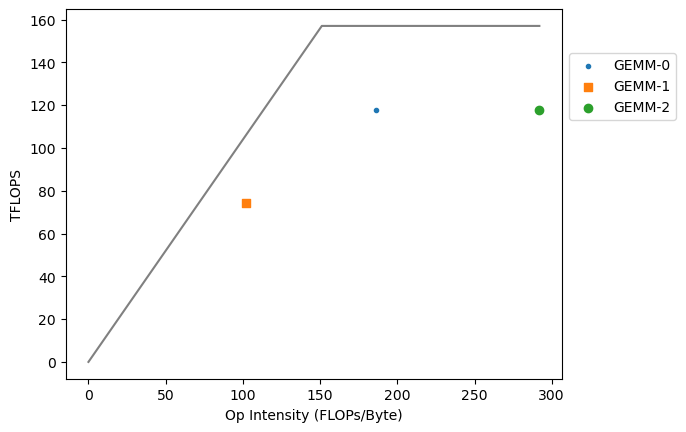

In [11]:
model_b3_bf16 = analysis_model(model_b3, A100_GPU, data_format_mem='bf16')
display(model_b3_bf16)

dot_roofline(model_b3_bf16, A100_GPU)
print(f'Total Cycles:{sum(model_b3_bf16.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b3_bf16.loc[:, "Total Data (MB)"]):0.2f}')
model_b3_bf16.to_csv('output_b4b.csv', index=False)

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 128, 512]",M,0.29,186.00,0.00,4342.08,134.09,0.50,0.06,0.12,0.69,33.81,1246.92,4342.08
1,GEMM,"[1, 128, 256, 128]",M,0.16,102.00,0.00,493.42,8.36,0.02,0.03,0.03,0.08,18.54,77.70,493.42
2,GEMM,"[1, 1024, 512, 256]",M,0.45,292.00,0.01,5526.28,267.91,0.25,0.12,0.50,0.88,53.08,2491.40,5526.28


Total Cycles:10361.78, Total data (MB): 1.64


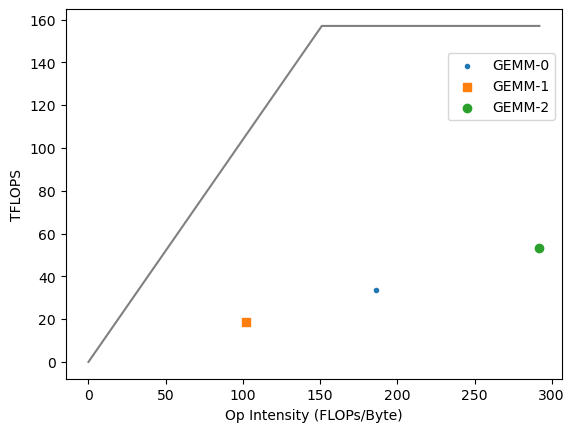

In [12]:
model_b3_fp64 = analysis_model(model_b3, A100_GPU, data_format_mem='fp64')
display(model_b3_fp64)

dot_roofline(model_b3_fp64, A100_GPU)
print(f'Total Cycles:{sum(model_b3_fp64.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b3_fp64.loc[:, "Total Data (MB)"]):0.2f}')
model_b3_fp64.to_csv('output_b4c.csv', index=False)

### B.3.ii) Change in compute ops 

Implement changes in ops_per_sec according to the data format of the model.


Please refer to the below table and scale the system.ops_per_sec for respective data formats.

|BF16 |	Int8 | FP32 | FP64 |
|----|----|----|----|
|X	| X*2 | X/2 | X/4 |


In [13]:
model_b3_int8_compute_adjusted = analysis_model(model_b3, A100_GPU, data_format_compute='int8')
display(model_b3_int8_compute_adjusted)
print(f'Total Cycles:{sum(model_b3_int8_compute_adjusted.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b3_int8_compute_adjusted.loc[:, "Total Data (MB)"]):0.2f}')
model_b3_int8_compute_adjusted.to_csv('output_b5a.csv', index=False)

model_b3_fp32_compute_adjusted = analysis_model(model_b3, A100_GPU, data_format_compute='fp32')
display(model_b3_fp32_compute_adjusted)
print(f'Total Cycles:{sum(model_b3_fp32_compute_adjusted.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b3_fp32_compute_adjusted.loc[:, "Total Data (MB)"]):0.2f}')
model_b3_fp32_compute_adjusted.to_csv('output_b5b.csv', index=False)

model_b3_fp64_compute_adjusted = analysis_model(model_b3, A100_GPU, data_format_compute='fp64')
display(model_b3_fp64_compute_adjusted)
print(f'Total Cycles:{sum(model_b3_fp64_compute_adjusted.loc[:, "Cycles"]):0.2f}, Total data (MB): {sum(model_b3_fp64_compute_adjusted.loc[:, "Total Data (MB)"]):0.2f}')
model_b3_fp64_compute_adjusted.to_csv('output_b5c.csv', index=False)

,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 128, 512]",M,0.14,186.00,0.00,2171.04,134.09,0.50,0.06,0.12,0.69,67.63,311.73,2171.04
1,GEMM,"[1, 128, 256, 128]",M,0.08,102.00,0.00,246.71,8.36,0.02,0.03,0.03,0.08,37.09,19.43,246.71
2,GEMM,"[1, 1024, 512, 256]",M,0.23,292.00,0.00,2763.14,267.91,0.25,0.12,0.50,0.88,106.17,622.85,2763.14


Total Cycles:5180.89, Total data (MB): 1.64


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 128, 512]",M,0.57,186.00,0.00,2171.04,134.09,0.50,0.06,0.12,0.69,67.63,1246.92,2171.04
1,GEMM,"[1, 128, 256, 128]",M,0.31,102.00,0.00,246.71,8.36,0.02,0.03,0.03,0.08,37.09,77.70,246.71
2,GEMM,"[1, 1024, 512, 256]",M,0.90,292.00,0.00,2763.14,267.91,0.25,0.12,0.50,0.88,106.17,2491.40,2763.14


Total Cycles:5180.89, Total data (MB): 1.64


,Op Type,Dimension,Bound,C/M ratio,Op Intensity,Latency (msec),Cycles,Num ops (MFLOP),Input_a (MB),Input_w (MB),Output (MB),Total Data (MB),Throughput (Tflops),Compute Cycles,Memory Cycles
0,GEMM,"[1, 1024, 128, 512]",C,1.15,186.00,0.00,2493.84,134.09,0.50,0.06,0.12,0.69,58.88,2493.84,2171.04
1,GEMM,"[1, 128, 256, 128]",M,0.63,102.00,0.00,246.71,8.36,0.02,0.03,0.03,0.08,37.09,155.41,246.71
2,GEMM,"[1, 1024, 512, 256]",C,1.80,292.00,0.00,4982.81,267.91,0.25,0.12,0.50,0.88,58.88,4982.81,2763.14


Total Cycles:7723.36, Total data (MB): 1.64
